In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd

# import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr

plt.style.use("papers")
# pw.overwrite_axisgrid()

COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]

FOLDER = "../../results/aggregated/"

DATA_TYPE = "FT"
EOC = "EC"

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
mne_info = mne.io.read_raw_eeglab("../../data/test_data_LEMON/sub-010002_EC.set")

montage_head = mne_info.info.get_montage()
ch_pos = montage_head.get_positions()["ch_pos"]
pos = np.stack([ch_pos[ch] for ch in mne_info.info["ch_names"]])

# now we calculate the radius from T7 and T8 x position
# (we could use Oz and Fpz y positions as well)
radius = np.abs(pos[[27, 14], 0]).mean() * 2.1

# then we obtain the x, y, z sphere center this way:
# x: x position of the Oz channel (should be very close to 0)
# y: y position of the T8 channel (should be very close to 0 too)
# z: average z position of Oz, Fpz, T7 and T8 (their z position should be the
#    the same, so we could also use just one of these channels), it should be
#    positive and somewhere around `0.03` (3 cm)
x = pos[27, 0]
y = pos[14, 1]
z = pos[27, -1]

Reading /Users/nikola/work-brain/eeg_microstate_and_latent_space/notebooks/paper1_figs/../../data/test_data_LEMON/sub-010002_EC.fdt


/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_37894/3308193063.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  mne_info = mne.io.read_raw_eeglab("../../data/test_data_LEMON/sub-010002_EC.set")
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_37894/3308193063.py:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_info = mne.io.read_raw_eeglab("../../data/test_data_LEMON/sub-010002_EC.set")


In [3]:
topo = xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))
topo.squeeze().sel({"data_type": EOC, "surrogate_type": DATA_TYPE}).rename({"decomposition_type": "algorithm"})

<xarray.DataArray (algorithm: 6, subject_id: 203, latent map: 4, channels: 61)>
[297192 values with dtype=float64]
Coordinates:
  * subject_id      (subject_id) object 'sub-010002' ... 'sub-010321'
  * latent map      (latent map) object 'A' 'B' 'C' 'D'
  * channels        (channels) int64 0 1 2 3 4 5 6 7 ... 53 54 55 56 57 58 59 60
    no_states       int64 ...
  * algorithm       (algorithm) object 'AAHC' 'ICA' 'PCA' 'TAAHC' 'hmm' 'kmeans'
    surrogate_type  <U2 'FT'
    data_type       <U2 'EC'

In [4]:
group_topo = (
    xr.open_dataarray(os.path.join(FOLDER, "group_topo.nc"))
    .squeeze()
    .dropna(dim="channels")
    .sel({"data_type": EOC, "surrogate_type": DATA_TYPE})
    .rename({"decomposition_type": "algorithm"})
)
rename_algs = {
    "AAHC": "AAHC",
    "TAAHC": "TAAHC",
    "ICA": "ICA",
    "PCA": "PCA",
    "hmm": "HMM",
    "kmeans": "mod. K-Means",
}
group_topo["algorithm"] = [
    rename_algs[str(alg.values)] for alg in group_topo["algorithm"]
]

In [5]:
mne_info.pick_channels(group_topo["channels"].values[:-1], ordered=True).info

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, C2, C3, CP3, CP5, F4, Oz, P1, P2, P4, P5, P6, P8, PO3, PO4, PO8
 chs: 16 EEG
 custom_ref_applied: False
 dig: 62 items (3 Cardinal, 59 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 250.0 Hz
>

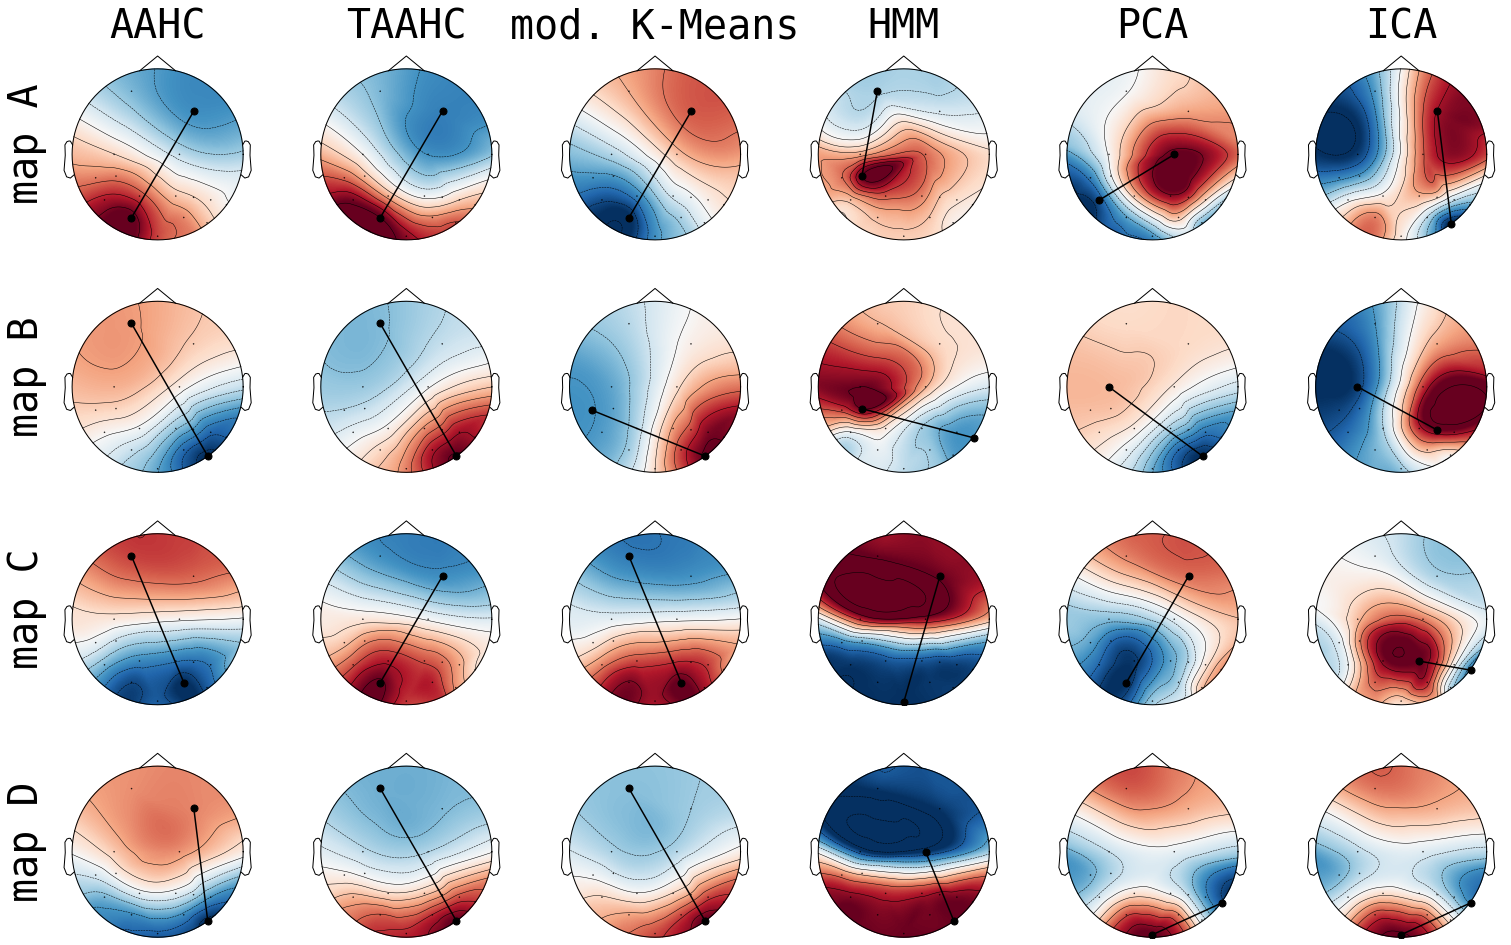

In [6]:
_, axs = plt.subplots(
    nrows=len(group_topo["latent map"]),
    ncols=len(group_topo["algorithm"]),
    figsize=(26, 15),
)
for i, algo in enumerate(COLUMNS_ORDER):
    axs[0, i].set_title(algo)
    for j, lmap in enumerate(group_topo["latent map"]):
        mne.viz.plot_topomap(
            group_topo.sel({"algorithm": algo, "latent map": lmap})
            .isel({"channels": slice(None, -1)})
            .values,
            mne_info.pick_channels(
                group_topo["channels"].values[:-1], ordered=True
            ).info,
            show=False,
            contours=10,
            sphere=(x, y, z, radius),
            axes=axs[j, i],
        )
        max_sen = np.argmax(
            group_topo.sel({"algorithm": algo, "latent map": lmap})
            .isel({"channels": slice(None, -1)})
            .values
        )
        min_sen = np.argmin(
            group_topo.sel({"algorithm": algo, "latent map": lmap})
            .isel({"channels": slice(None, -1)})
            .values
        )
        pos_int = mne.channels.layout._find_topomap_coords(
            mne_info.pick_channels(
                group_topo["channels"].values[:-1], ordered=True
            ).info,
            picks="eeg",
        )
        axs[j, i].plot(
            [pos_int[min_sen, 0], pos_int[max_sen, 0]],
            [pos_int[min_sen, 1], pos_int[max_sen, 1]],
            "ko-",
            markersize=7,
            lw=1.5,
        )
        # axs[j, i].set_xlabel(
        #     f"r={group_topo.sel({'algorithm': algo, 'latent map': lmap}).isel({'channels': -1}).values:.3f}"
        # )
        axs[j, 0].set_ylabel(f"map {lmap.values}", size=40)
plt.savefig(fname=f"LEMON_{DATA_TYPE}_{EOC}topomaps.pdf", transparent=True)